# Lidando com classes desbalanceadas

Nossa proposta é apresentar de forma simples um tratamento de classes desbalanceadas usando uma base de dados de pessoas que possuem ou não crédito aprovado.

Criamos um modelo classificador para prever classes em novas base de dados.

#### Importando os módulos necessários

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

#Módulos para lidar com as classes desbalanceadas
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

#Módulos de ML. Usaremos o modelo de Regressão Logística
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression #Vamos usar nesse script o modelo de Regressão Logística
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#### Importando o dataset (base de dados que tem crédito aprovado ou não)

In [2]:
df = pd.read_csv('bank-full.csv',sep=';')
df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


#### Analisando a base de dados

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


#### Imprimindo os valores das colunas categóricas

In [4]:
for i in df.keys():
    if df[i].dtypes == 'O':
        print(f'Os valores da coluna {i} são {pd.unique(df[i])}')

Os valores da coluna job são ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
Os valores da coluna marital são ['married' 'single' 'divorced']
Os valores da coluna education são ['tertiary' 'secondary' 'unknown' 'primary']
Os valores da coluna default são ['no' 'yes']
Os valores da coluna housing são ['yes' 'no']
Os valores da coluna loan são ['no' 'yes']
Os valores da coluna contact são ['unknown' 'cellular' 'telephone']
Os valores da coluna month são ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
Os valores da coluna poutcome são ['unknown' 'failure' 'other' 'success']
Os valores da coluna y são ['no' 'yes']


#### Transformando algumas colunas categóricas em numéricas (usando pd. map())
 Education, Default, Housing, Loan, Contact, Poutcome, y e Month

In [5]:
df['education'] = df['education'].map({'primary':0,'secondary':1,'tertiary':2})
df['default'] = df['default'].map({'no':0,'yes':1})
df['housing'] = df['housing'].map({'no':0,'yes':1})
df['loan'] = df['loan'].map({'no':0,'yes':1})
df['contact'] = df['contact'].map({'cellular':0,'unknown':1,'telephone':2})
df['poutcome'] = df['poutcome'].map({'unknown':0,'failure':1,'other':2,'success':3})
df['y'] = df['y'].map({'no':0,'yes':1})
df['month'] = pd.to_datetime(df['month'],format='%b').dt.month

In [6]:
df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,2.0,0,2143,1,0,1,5,5,261,1,-1,0,0,0
1,44,technician,single,1.0,0,29,1,0,1,5,5,151,1,-1,0,0,0
2,33,entrepreneur,married,1.0,0,2,1,1,1,5,5,76,1,-1,0,0,0
3,47,blue-collar,married,NaN,0,1506,1,0,1,5,5,92,1,-1,0,0,0
4,33,unknown,single,NaN,0,1,0,0,1,5,5,198,1,-1,0,0,0
5,35,management,married,2.0,0,231,1,0,1,5,5,139,1,-1,0,0,0
6,28,management,single,2.0,0,447,1,1,1,5,5,217,1,-1,0,0,0
7,42,entrepreneur,divorced,2.0,1,2,1,0,1,5,5,380,1,-1,0,0,0
8,58,retired,married,0.0,0,121,1,0,1,5,5,50,1,-1,0,0,0
9,43,technician,single,1.0,0,593,1,0,1,5,5,55,1,-1,0,0,0


#### Checando dados faltantes (missing values)

In [7]:
df.isnull().sum()

age             0
job             0
marital         0
education    1857
default         0
balance         0
housing         0
loan            0
contact         0
day             0
month           0
duration        0
campaign        0
pdays           0
previous        0
poutcome        0
y               0
dtype: int64

Uma forma de lidar com esses dados faltantes é eliminando-os

In [8]:
df.dropna(inplace=True)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,2.0,0,2143,1,0,1,5,5,261,1,-1,0,0,0
1,44,technician,single,1.0,0,29,1,0,1,5,5,151,1,-1,0,0,0
2,33,entrepreneur,married,1.0,0,2,1,1,1,5,5,76,1,-1,0,0,0
5,35,management,married,2.0,0,231,1,0,1,5,5,139,1,-1,0,0,0
6,28,management,single,2.0,0,447,1,1,1,5,5,217,1,-1,0,0,0


Consultando novamente o se existe dados faltantes

In [9]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

#### Transformando o restante das colunas categóricas em numéricas (usando pd.get_dummies())

In [11]:
df = pd.get_dummies(df)
df.head()

,age,education,default,balance,housing,loan,contact,day,month,duration,...,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single
0,58,2.0,0,2143,1,0,1,5,5,261,...,0,0,0,0,0,0,0,0,1,0
1,44,1.0,0,29,1,0,1,5,5,151,...,0,0,0,0,1,0,0,0,0,1
2,33,1.0,0,2,1,1,1,5,5,76,...,0,0,0,0,0,0,0,0,1,0
5,35,2.0,0,231,1,0,1,5,5,139,...,0,0,0,0,0,0,0,0,1,0
6,28,2.0,0,447,1,1,1,5,5,217,...,0,0,0,0,0,0,0,0,0,1


#### Visualizando a distribuição das classes (coluna 'y')

In [12]:
df['y'].value_counts()

0    38317
1     5037
Name: y, dtype: int64

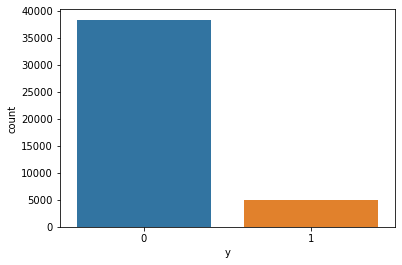

In [13]:
sns.countplot(x='y',data=df)

com esses resultados vemos que as classes estão realmente desbalanceandas!!

#### Executando o algorítmo classificador

In [14]:
lr = LogisticRegression()

Repare que estamos usando os valores padrões do parâmetros do modelo.

#### Separando os dados e suas classes

In [48]:
X = df.drop('y',axis=1)
y = df['y']

#### Separando os dados

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [50]:
y_train.count() , y_test.count()

(30347, 13007)

#### Treinando o modelo

In [51]:
lr.fit(X_train,y_train)

/home/cosmology/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

#### Usando o modelo treinado

In [52]:
y_pred = lr.predict(X_test)

#### Checando a acurácia do modelo

In [53]:
accuracy_score(y_test,y_pred)

0.8924425309448758

#### Verificando o relatório de classificação

In [54]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     11496
           1       0.60      0.22      0.32      1511

    accuracy                           0.89     13007
   macro avg       0.75      0.60      0.63     13007
weighted avg       0.87      0.89      0.87     13007



Por mais que a acurácia tenha dado um resultado bom verificamos no relatório de classificação que o algorítmo falha ao tentar classificar a classe '1' (observe o recall), ou seja, o modelo está extremamente enviesado (ficou especialista em classificar a classe '0'). A justificativa de isto estar acontecendo se deve ao fato de termos poucos exemplos da classe '1'.

Este problema pode ser visto através da matriz de confusão

In [28]:
print(pd.crosstab(y_test, y_pred, rownames=['Real'],colnames=['Predito'],margins=True))

Predito      0    1    All
Real                      
0        11278  218  11496
1         1181  330   1511
All      12459  548  13007


Vamos a partir deste ponto tratar dessas classe desbalanceadas!!

## Aplicando NearMiss

O NearMiss é um método de under_sampling. Esta função iguala as quantidades das amostras entre as classes, reduzindo as amostras da classe majoritária, mas tentando manter a separabilidade dos dados.

In [55]:
from imblearn.under_sampling import NearMiss

#### Instânciando o NearMiss

In [56]:
nr = NearMiss()

#### Aplicando o NearMiss

In [57]:
X = df.drop('y',axis=1)
y = df['y']
X, y = nr.fit_sample(X,y)

#### Checando a quantidade de amostras entre as classes depois de aplicar o NearMiss

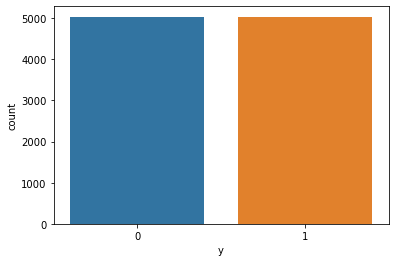

In [58]:
sns.countplot(x=y)

Percebemos que a quantidade de amostra estão igualádas!!

Agora, podemos revalidar o algorítmo.

#### Separando os dados

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

y_train.count() , y_test.count()

(7051, 3023)

#### Treinando o modelo

In [60]:
lr.fit(X_train,y_train)

/home/cosmology/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

#### Usando o modelo treinado

In [61]:
y_pred = lr.predict(X_test)

#### Checando a acurácia do modelo

In [62]:
accuracy_score(y_test,y_pred)

0.8746278531260337

#### Verificando o relatório de classificação

In [63]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1511
           1       0.90      0.84      0.87      1512

    accuracy                           0.87      3023
   macro avg       0.88      0.87      0.87      3023
weighted avg       0.88      0.87      0.87      3023



#### Verificando a Matriz de confusão

In [64]:
print(pd.crosstab(y_test, y_pred, rownames=['Real'],colnames=['Predito'],margins=True))

Predito     0     1   All
Real                     
0        1370   141  1511
1         238  1274  1512
All      1608  1415  3023


Depois de termos feito o tratamento das classes desbalanceadas, percebemos que nosso algorítmo tem sucesso para classificar instancias que são da classe '1'.

### Teste de Overfitting

Imprimindo a acurácia do modelo fitado com dados de treino

In [67]:
accuracy_score(y_test,y_pred)

0.8746278531260337

Testando o modelo com os dados de treino

In [70]:
ypred = lr.predict(X_train)
accuracy_score(y_train,ypred)

0.8872500354559637

Observe que esse modelo não sofre de overfitting.

## Aplicando o SMOTE

Agora, vamos tratar a base de dados desbalancedas com outra técnica: Over-sampling. Aqui, usamos o algorítmo SMOTE. Este gera dados sintéticos da classe minoritária, para tentar igualar essa classe com a classe majoritária.

Vamos rodar novamente a base de dados

In [71]:
X = df.drop('y',axis=1)
y = df['y']

#### Visualizando a quantidade de dados por classe

In [72]:
np.bincount(y)

array([38317,  5037])

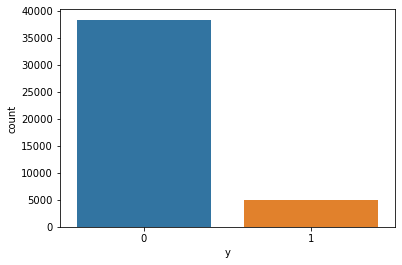

In [73]:
sns.countplot(x=y)

Vamos então gerar dados sintéticos utilizando o SMOTE para aumentar os dados da classe '1'.

#### Instanciando o SMOTE

In [74]:
smt = SMOTE()

Obs: Com o parametro sampling_strategy controlamos a quantidade de dados sintéticos gerados. Se valor vai de 0 a 1. A princípio, vamos usar o valor padrão, 'Auto' (100%), que aumenta a classe minoritária para exatamente o mesmo valor da classe majoritária.

#### Aplicando o SMOTE nos dados

In [75]:
X, y = smt.fit_sample(X,y)

#### Visualizando a quantidade de dados por classe

In [76]:
np.bincount(y)

array([38317, 38317])

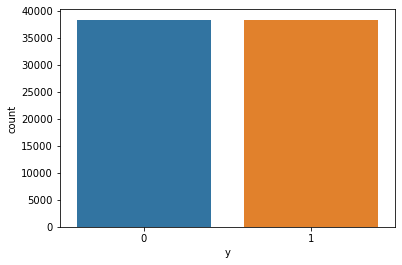

In [77]:
sns.countplot(x=y)

Vamos agora gerar o Classificador.

#### Separando os dados

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

y_train.count() , y_test.count()

(53643, 22991)

#### Treinando o modelo

In [79]:
lr = LogisticRegression()
lr.fit(X_train,y_train)

/home/cosmology/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

#### Usando o modelo treinado

In [80]:
y_pred = lr.predict(X_test)

#### Checando a acurácia do modelo

In [81]:
accuracy_score(y_test,y_pred)

0.8690792049062677

#### Verificando o relatório de classificação

In [82]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.85      0.87     11495
           1       0.86      0.89      0.87     11496

    accuracy                           0.87     22991
   macro avg       0.87      0.87      0.87     22991
weighted avg       0.87      0.87      0.87     22991



Observe que tivemos resultados melhores no relatório de classificação do modelo que usa o método NearMiss. 

Este baixo desempenho do modelo usando o SMOTE pode estar ligado, por exemplo, na utilização de dados sintéticos ("falsos dados") que o SMOTE cria para treinar o classificador.

#### Matriz de Confusão

In [24]:
print(pd.crosstab(y_test, y_pred, rownames=['Real'],colnames=['Predito'],margins=True))

Predito      0      1    All
Real                        
0         8869   2626  11495
1         1900   9596  11496
All      10769  12222  22991


### Teste de Overfitting

Imprimindo a acurácia do modelo fitado com dados de treino

In [83]:
accuracy_score(y_test,y_pred)

0.8690792049062677

Testando o modelo com os dados de treino

In [85]:
ypred = lr.predict(X_train)
accuracy_score(y_train,ypred)

0.8704770426709916

Observe que esse modelo também não sofre de overfitting.

A escolha do método de classes desbalanceadas dependerá, por exemplo, da base de dados que estamos usando. Imagine que temos uma base de dados com 500 entradas, 400 são da classe '0' e 100 da classe '1'. Como a quantidade de entradas já é pequena, o recomendado é usar o método SMOTE do over-sampling, para gerar dados sintéticos e, assim, aumentar o dados da classe '1'.

Observe que usando a configuração padrão do parâmetro sampling_strategy de SMOTE induz nosso modelo a sofre de overfitting, fazendo nosso modelo especialista nos dados de treino, fazendo assim previsões falhas para novos dados.

## Usando o método SMOTE com parâmetro sampling_strategy = 0.5 (aumento de 50%)

#### Instanciando o SMOTE

In [86]:
smt = SMOTE(sampling_strategy = 0.5)

#### Aplicando o SMOTE nos dados

In [87]:
X = df.drop('y',axis=1)
y = df['y']
X, y = smt.fit_sample(X,y)

#### Visualizando a quantidade de dados por classe

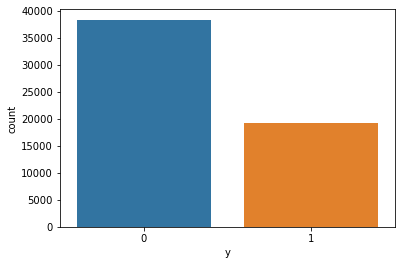

In [88]:
sns.countplot(x=y)

#### Separando os dados

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

y_train.count() , y_test.count()

(40232, 17243)

#### Treinando o modelo

In [90]:
lr = LogisticRegression()
lr.fit(X_train,y_train)

/home/cosmology/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

#### Usando o modelo treinado

In [91]:
y_pred = lr.predict(X_test)

#### Checando a acurácia do modelo

In [92]:
accuracy_score(y_test,y_pred)

0.8218407469697848

#### Verificando o relatório de classificação

In [93]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87     11495
           1       0.77      0.66      0.71      5748

    accuracy                           0.82     17243
   macro avg       0.81      0.78      0.79     17243
weighted avg       0.82      0.82      0.82     17243



#### Matriz de Confusão

In [94]:
print(pd.crosstab(y_test, y_pred, rownames=['Real'],colnames=['Predito'],margins=True))

Predito      0     1    All
Real                       
0        10387  1108  11495
1         1964  3784   5748
All      12351  4892  17243


### Teste de Overfitting

Imprimindo a acurácia do modelo fitado com dados de treino

In [95]:
accuracy_score(y_test,y_pred)

0.8218407469697848

Testando o modelo com os dados de treino

In [97]:
ypred = lr.predict(X_train)
accuracy_score(y_train,ypred)

0.8260837144561542

Observe que esse modelo usando sampling_strategy de 50% também não sofre de overfitting e ainda por cima a diferença entre as acurácias é ainda menor.